# Nginx log analysis with pandas and matplotlib

By Jess Johnson [http://grokcode.com](http://grokcode.com)

This notebook analyzes Nginx access logs in order to estimate the capacity needed to survive a traffic spike. I'm looking at access logs for [Author Alcove](http://authoralcove.com) which was hit by a big traffic spike when it spent around 24 hours at the top of [/r/books](http://reddit.com/r/books/). The site was hugged to death by reddit. Visitors experienced very slow load times, and many people couldn't access the site at all due to 50x errors. So let's estimate how much extra capacity would be needed to survive this spike.

The source for this notebook is located on [github](https://github.com/grokcode/ipython-notebooks). See a mistake? Pull requests welcome.

Thanks to Nikolay Koldunov for his [notebook on Apache log analysis](http://nbviewer.ipython.org/github/koldunovn/nk_public_notebooks/blob/master/Apache_log.ipynb), and thanks to my bro Aaron for the much needed optimism and server optimization tips while everything was on fire.

OK let's get started.

## Setup

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Let's import the usual suspects.

In [2]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

We will also use [apachelog](https://code.google.com/p/apachelog/), which is a module for parsing apache logs, but it works fine with nginx logs as long as we give it the right format string. You can install it with `pip install apachelog`.  

In [ ]:
import apachelog

## Parsing the log

I started out by doing some command line preprocessing on the log in order to remove bots. I used `egrep -v` to filter out the bots that were hitting the site the most often. These were Googlebot, Bingbot, the New Relic uptime checker, Buidu spider, and a few others. A more careful approach would filter out everything on one of the known bot lists ([like this one](http://www.robotstxt.org/db.html)), but I'm going to play it a bit fast and loose.

First of all let's get a sample line out of the `access.log` and try to parse it. Here is a description of the codes in the log format we are working with:

    %h          - remote host (ie the client IP)
    %l          - identity of the user determined by identd (not usually used since not reliable)
    %u          - user name determined by HTTP authentication
    %t          - time the server finished processing the request.
    %r          - request line from the client. ("GET / HTTP/1.0")
    %>s         - status code sent from the server to the client (200, 404 etc.)
    %b          - size of the response to the client (in bytes)
    %i      - Referer is the page that linked to this URL.
    User-agent  - the browser identification string
    %V          - the server name according to the UseCanonicalName setting

In [3]:
sample_string = '178.137.91.215 - - [21/Feb/2014:06:44:53 +0000] "GET /work/homepages-maths-year-6/ HTTP/1.0" \
200 10427 "http://authoralcove.com/work/homepages-maths-year-6/" "Opera/9.80 (Windows NT 6.1; WOW64; U; ru) \
Presto/2.10.289 Version/12.00" "-"'
nformat = r'%h %l %u %t \"%r\" %>s %b \"%i\" \"%{User-Agent}i\" \"%V\"'
p = apachelog.parser(nformat)
data = p.parse(sample_string)
data

{'%>s': '200',
 '%V': '-',
 '%b': '10427',
 '%h': '178.137.91.215',
 '%i': 'http://authoralcove.com/work/homepages-maths-year-6/',
 '%l': '-',
 '%r': 'GET /work/homepages-maths-year-6/ HTTP/1.0',
 '%t': '[21/Feb/2014:06:44:53 +0000]',
 '%u': '-',
 '%{User-Agent}i': 'Opera/9.80 (Windows NT 6.1; WOW64; U; ru) Presto/2.10.289 Version/12.00'}

Now let's parse each line while preparing the access time so that pandas will be able to handle it.

In [4]:
from apachelog import ApacheLogParserError
log_list = []
with open('./private-data/access.log') as f:
    for line in f.readlines():
        try:
            data = p.parse(line)
        except ApacheLogParserError:
            sys.stderr.write("Unable to parse %s" % line)
        data['%t'] = data['%t'][1:12]+' '+data['%t'][13:21]+' '+data['%t'][22:27]
        log_list.append(data)

Loading into pandas.

In [5]:
from pandas import Series, DataFrame, Panel
df = DataFrame(log_list)
df[0:2]

%>s %V     %b              %h  \
0  200  -  10427  178.137.91.215   
1  200  -   7507    202.46.54.40   

                                                  %i %l  \
0  http://authoralcove.com/work/homepages-maths-y...  -   
1                                                  -  -   

                                           %r                          %t %u  \
0  GET /work/homepages-maths-year-6/ HTTP/1.0  21/Feb/2014 06:44:53 +0000  -   
1                              GET / HTTP/1.1  21/Feb/2014 06:53:47 +0000  -   

                                      %{User-Agent}i  
0  Opera/9.80 (Windows NT 6.1; WOW64; U; ru) Pres...  
1  Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...  

[2 rows x 10 columns]

Now lets clean up the pandas dataframe a bit by deleting some columns we aren't interested in and renaming the remaining columns.

In [6]:
del df['%V']
del df['%h']
del df['%i']
del df['%l']
del df['%u']
del df['%{User-Agent}i']
df[0:2]

%>s     %b                                          %r  \
0  200  10427  GET /work/homepages-maths-year-6/ HTTP/1.0   
1  200   7507                              GET / HTTP/1.1   

                           %t  
0  21/Feb/2014 06:44:53 +0000  
1  21/Feb/2014 06:53:47 +0000  

[2 rows x 4 columns]

In [7]:
df = df.rename(columns={'%>s': 'Status', '%b':'b', 
                        '%r':'Request', '%t': 'Time'})
df[0:2]

Status      b                                     Request  \
0    200  10427  GET /work/homepages-maths-year-6/ HTTP/1.0   
1    200   7507                              GET / HTTP/1.1   

                         Time  
0  21/Feb/2014 06:44:53 +0000  
1  21/Feb/2014 06:53:47 +0000  

[2 rows x 4 columns]

Massage the data a bit more so that the access time is a `datetime`, status is an `int`, and the response size is in MB, with missing data represented as `NaN`, not `-`.

In [8]:
df.index = pd.to_datetime(df.pop('Time'))

In [9]:
df['Status'] = df['Status'].astype('int')

In [10]:
def dash2nan(x):
    if x == '-':
        x = np.nan
    else:
        x = float(x)/1048576.
    
    return x
df['b'] = df['b'].apply(dash2nan)

## Analysis

Let's graph the data to visualize what is happening.

First let's increase the graph size.

In [11]:
from pylab import *
rcParams['figure.figsize'] = 10, 5 # width, height in inches

Now let's graph the requests hitting the web server. `10t` will use a 10 minute interval size, so each point on the graph shows the number of requestes in a 10 minute window.

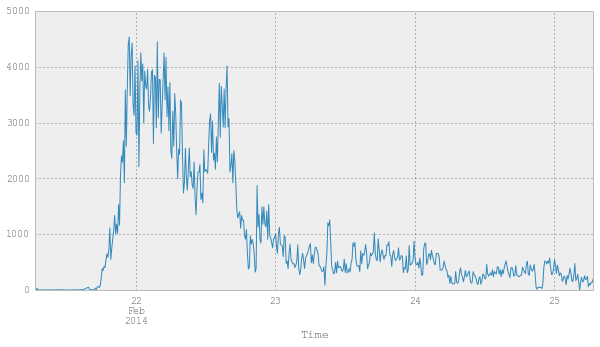

In [77]:
df_s = df['Status'].resample('10t', how='count')
df_s.plot()


Above we see that we were peaking at around 4500 requests every 10 minutes, or about 450 requests a minute. There was a quick ramp up as the site climbed to the top position on /r/books, then a drop off overnight (for US timezones), another peak the next day as people woke up, and then a decline as the site fell back down the /r/books page.

Let's see how the server held up by looking at some response codes.

In [16]:
df['Status'].value_counts()

200    413236
502     39769
499     37443
304     29777
302      9467
404      8171
504      8105
301      1743
401       677
403       262
500       171
206        51
444        40
400        20
408         4
405         1
dtype: int64

There are quite a few 500 errors here. 499 errors are also bad news because it means that the client closed the connection before the page could be served. These are almost certainly because the site wasn't responding in a reasonable timeframe.

Let's graph the response codes.

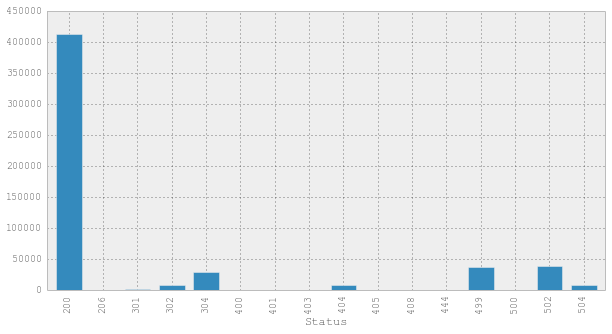

In [17]:
grouped_status = df.groupby('Status')
grouped_status.size().plot(kind='bar')

OK that doesn't look too bad. The vast majority of requests were served a 200 (OK) response.

Let's graph the most common response codes over time, with a sample timespan of 1 hour.

In [110]:
t_span = '60t'
df_200 = df['Status'][df['Status'] == 200].resample(t_span, how='count')
df_502 = df['Status'][df['Status'] == 502].resample(t_span, how='count')
df_499 = df['Status'][df['Status'] == 499].resample(t_span, how='count')
df_304 = df['Status'][df['Status'] == 304].resample(t_span, how='count')
df_302 = df['Status'][df['Status'] == 302].resample(t_span, how='count')
df_404 = df['Status'][df['Status'] == 404].resample(t_span, how='count')
df_504 = df['Status'][df['Status'] == 504].resample(t_span, how='count')
df_301 = df['Status'][df['Status'] == 301].resample(t_span, how='count')


status_df = DataFrame({'OK': df_200, 
                       'Bad Gateway': df_502, 
                       'Client Closed': df_499, 
                       'Not Modified': df_304, 
                       'Found': df_302, 
                       'Not Found': df_404,
                       'Gateway Timeout': df_504,
                       'Moved Permenantely': df_301})

In [111]:
status_df.fillna(0, inplace=True)
status_df[0:5]

Bad Gateway  Client Closed  Found  Gateway Timeout  \
Time                                                                      
2014-02-21 06:00:00            0              0      0                0   
2014-02-21 07:00:00            0              0      3                0   
2014-02-21 08:00:00            0              0      0                0   
2014-02-21 09:00:00            0              0      0                0   
2014-02-21 10:00:00            0              6      0                3   

                     Moved Permenantely  Not Found  Not Modified  OK  
Time                                                                  
2014-02-21 06:00:00                   0          0             0   3  
2014-02-21 07:00:00                   0          4             1  29  
2014-02-21 08:00:00                   0          0             0   2  
2014-02-21 09:00:00                   0          2             0   3  
2014-02-21 10:00:00                   0          0             0   2  

[5 rows x 8 columns]

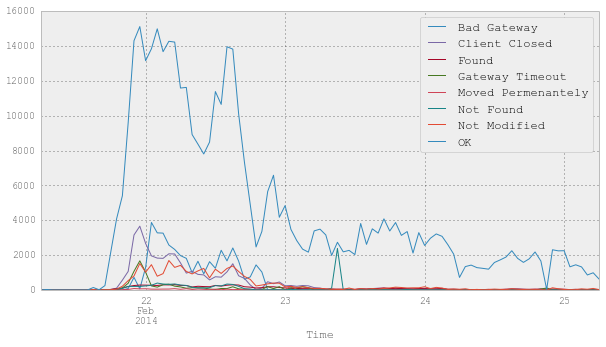

In [112]:
status_df.plot()
legend()

This doesn't look too bad either, but it's hard to make sense of what is going on with so many different response codes. Let's group them into success (web server handled it as expected) and failure (web server error or client closed request).

    200    413236    Success    OK 
    502     39769    Failure    Bad Gateway
    499     37443    Failure    Client closed request
    304     29777    Success    Not modified
    302      9467    Success    Found
    404      8171    Success    Not Found
    504      8105    Failure    Gateway timeout
    301      1743    Success    Moved permanently
    401       677    Success    Unauthorized
    403       262    Success    Forbidden
    500       171    Failure    Internal server error
    206        51    Success    Partial content
    444        40    Failure?   No response
    400        20    Success?   Bad request
    408         4    Success?   Request timeout
    405         1    Success?   Method not allowed

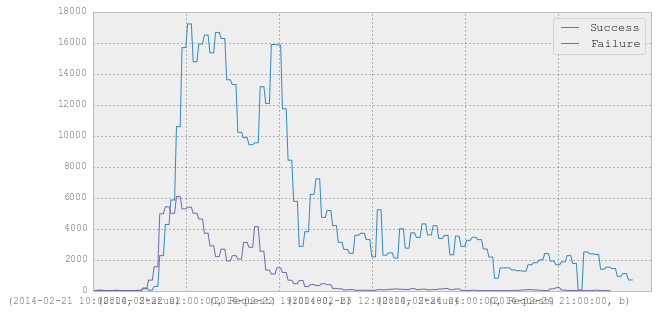

In [113]:
success_df = df[df['Status'].isin([200, 304, 302, 404, 301, 401, 403, 206, 444, 400, 408, 405])].resample(t_span, how='count')
fail_df = df[df['Status'].isin([502, 499, 504, 500, 444])].resample(t_span, how='count')
success_df.plot(label="Success")
fail_df.plot(label="Failure")
legend()

Those are the requests served by nginx, so it includes both static files like css and javascript and dynamic content that was passed off to the Django app running on uwsgi. Let's filter out the static files and see how uwsgi did. In this case almost all of the static files have `/static/` in the path with a few exceptions such as the `favicon.ico`.


In [114]:
dynamic_df = df[df['Request'].str.contains(r'^GET /(static|favicon.ico)') == False]
dynamic_df[0:10]

Status         b  \
Time                                    
2014-02-21 06:44:53     200  0.009944   
2014-02-21 06:53:47     200  0.007159   
2014-02-21 06:54:22     200  0.007159   
2014-02-21 07:01:28     200  0.002501   
2014-02-21 07:02:11     200  0.004643   
2014-02-21 07:03:06     302  0.000000   
2014-02-21 07:03:07     200  0.003963   
2014-02-21 07:03:41     200  0.001887   
2014-02-21 07:03:48     200  0.002122   
2014-02-21 07:03:55     200  0.002145   

                                                               Request  
Time                                                                    
2014-02-21 06:44:53         GET /work/homepages-maths-year-6/ HTTP/1.0  
2014-02-21 06:53:47                                     GET / HTTP/1.1  
2014-02-21 06:54:22                                     GET / HTTP/1.1  
2014-02-21 07:01:28                                     GET / HTTP/1.1  
2014-02-21 07:02:11             GET /accounts/create-account/ HTTP/1.1  
2014-02-21 07:03:06            POST /accounts/create-account/ HTTP/1.1  
2014-02-21 07:03:07             GET /work/lists/most-popular/ HTTP/1.1  
2014-02-21 07:03:41  GET /work/lists/most-popular/?page=2&querystri...  
2014-02-21 07:03:48  GET /work/lists/most-popular/?page=3&querystri...  
2014-02-21 07:03:55  GET /work/lists/most-popular/?page=4&querystri...  

[10 rows x 3 columns]

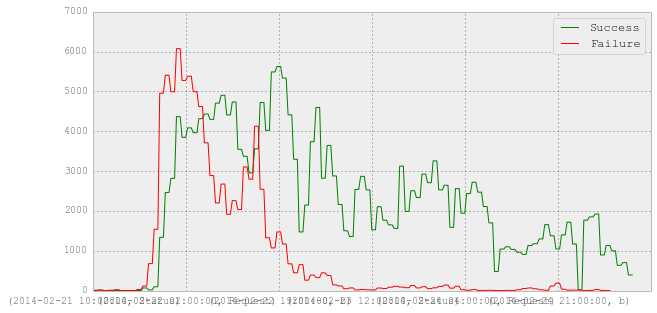

In [115]:
success_df = dynamic_df[dynamic_df['Status'].isin([200, 304, 302, 301, 401])].resample(t_span, how='count')
fail_df = dynamic_df[dynamic_df['Status'].isin([502, 499, 504, 500])].resample(t_span, how='count')
success_df.plot(label="Success", color="g")
fail_df.plot(label="Failure", color="r")
legend()

Ouch! So during the initial peak, uwsgi is failing more often than not. Let's look at the same data in a stacked bar chart.

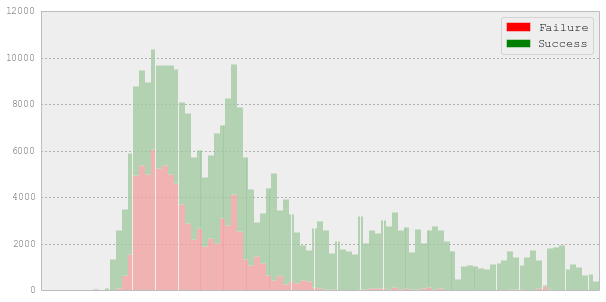

In [116]:
responses_df = DataFrame({'Success': success_df, 
                          'Failure': fail_df,
                          })
responses_df.plot(kind="bar", stacked=True, xticks=(), colors=("r", "g",))

It looks like about 2,000 requests / hour is all uwsgi can handle before it starts to throw errors. That is only about 1 request every two seconds so that is a pretty big problem.

We needed to handle 10,000 requests / hour, but we were only able to handle 2,000 requests / hour. So it looks like we would need roughly 5x the capacity to handle a spike of this size. This is a little bit misleading though because many visitors abandoned the site after hitting 50X errors and long page loads.

Here is a view of the same traffic spike from Google Analytics.

![Google Analytics Pageviews vs. Pages per Visit](files/data/google-analytics.png)

During the spike, pages per visit were roughly half of what they normally were, so let's double the 5x estimate and plan for 10x the capacity to handle this load.

## Solutions

One solution is to upgrade the server running uwsgi and use ten times the number of workers to handle requests, but let's see if we can be a bit smarter.

Another solution is to optimize the web app by shortening long-running requests, but I have already picked most of the low hanging fruit there. 

Let's investigate to see if there are any opportunities to prevent requests from hitting uwsgi in the first place.

First let's get a count pages with the most requests.


In [119]:
dynamic_df['Request'].value_counts().head(40)

GET / HTTP/1.1                                                  48707
GET /work/lists/most-popular/ HTTP/1.1                          19818
GET /accounts/create-account/ HTTP/1.1                          10301
GET /apple-touch-icon.png HTTP/1.1                               9591
POST /accounts/create-account/ HTTP/1.1                          6537
GET /work/lists/most-popular/?page=2&querystring_key=page HTTP/1.1     6335
GET /work/lists/highest-rated/ HTTP/1.1                          5819
GET /accounts/login/ HTTP/1.1                                    3502
GET /work/lists/most-popular/?page=3&querystring_key=page HTTP/1.1     3055
GET /work/lists/most-popular/?page=4&querystring_key=page HTTP/1.1     2208
POST /accounts/login/ HTTP/1.1                                   2071
GET /work/lists/most-popular/?page=5&querystring_key=page HTTP/1.1     1699
POST /work/rate/195559/ HTTP/1.1                                 1462
POST /work/rate/182662/ HTTP/1.1                                 1

There isn't much that can be done with the POST requests - they need to hit uwsgi so we can save new accounts or ratings in the database. So let's move on to the GET requests. There are two basic techniques for having nginx serve these pages. First, we could have uwsgi store the fully rendered page in memcached or similar, then have nginx try to pull the page from memcached and falling back to uwsgi if the page wasn't in the cache. The second idea is to have uwsgi create a static file, and then let nginx serve that if it exists. Unfortunately, in this case both of those solutions are problematic. It is beyond the scope of this notebook to go into details (hopefully I will have a separate blog post on that soon), but the gist is that for most of these pages, the content changes depending on who is viewing them, so they can't readily be cached at the page level.

The biggest gain would be to make the homepage static. The homepage will redirect to a user's recommended page if they are already logged in, but we could possibly detect logged in users with nginx via the http headers and only serve the static page to logged out visitors. Let's see what proportion of visitors who hit the homepage were logged in already.

In [140]:
dynamic_df[dynamic_df['Request'].str.contains('GET / HTTP/1.1')]['Status'].value_counts()

200    19331
502    12559
499    10781
302     3053
504     2036
301      946
500        1
dtype: int64

Of the visitors who were able to access the homepage, (19331 / (3053 + 946 + 19331)) * 100 = 83% were logged out. So that nginx configuration change would have saved a bit more than 40,000 requests.

Out of how many total?

In [141]:
dynamic_df.count()

Status     307402
b          307402
Request    307402
dtype: int64

So that change alone would offload 13% of uwsgi's request load to nginx. That's a good start.

Another thing that jumps out is that `/apple-touch-icon.png` and `/apple-touch-icon-precomposed.png` don't actually exist have to be passed off to uwsgi before they 404. Setting up nginx to serve anything ending in `.png` will save some requests. Let's see if there are any other files like that.

In [134]:
dynamic_df[dynamic_df['Request'].str.contains(r'(png |xml |gif )')]['Request'].value_counts().head(10)

GET /apple-touch-icon.png HTTP/1.1                        9591
GET /apple-touch-icon-precomposed.png HTTP/1.1             768
GET /apple-touch-icon-120x120-precomposed.png HTTP/1.1     103
GET /apple-touch-icon-120x120.png HTTP/1.1                  91
GET /apple-touch-icon-152x152-precomposed.png HTTP/1.1      36
GET /browserconfig.xml HTTP/1.1                             35
GET /apple-touch-icon-152x152.png HTTP/1.1                  33
GET /blog/images/logo3.png HTTP/1.1                         18
GET /apple-touch-icon-76x76-precomposed.png HTTP/1.1        14
GET /blog/atom.xml HTTP/1.1                                 13
dtype: int64

Let's see how many requests that will save.

In [137]:
dynamic_df[dynamic_df['Request'].str.contains(r'(png |xml |gif )')].count()

Status     10870
b          10870
Request    10870
dtype: int64

That is another 3.5% of requests.

Between those two changes we will save 16.5% of requests from hitting uwsgi. It isn't enough to prevent the need for a server upgrade, but it does get us a bit closer.